# Recap 
### Walkthrough of PINN Algorithm:

1. **Define Problem (ODEs/PDE)**
2. **Initialize Neural Network** ```class PINN(nn.Module):```
3. **Compute ODE Residuals (Use automatic differentiation)**: ```def pde_residual, def initial_condition, def boundary_condition(x, t)```
4. **Define Loss Function** ```def loss_fn```
   - Data Loss
   - Residual loss
   - Initial condition loss
   - Total Loss
5. **Train the Network** ```def train```
    - **Epoch Loop**   
    - **Loss Calculation**
    - **Gradient Calculation**
    - **Optimizer Update**
5. **Progress Logging**
6. **Evaluate Results**
7. **Visualize Results**

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__() # super().__init__() ensures that the parent class (nn.Module) is properly initialized.
        self.dense1 = nn.Linear(1, 64)  # Assuming t has shape [N, 1]
        self.dense2 = nn.Linear(64, 64)
        self.dense3 = nn.Linear(64, 2)  # Output: [x(t), y(t)]

    def forward(self, t):
        t = torch.tanh(self.dense1(t))
        t = torch.tanh(self.dense2(t))
        return self.dense3(t)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the neural network model class for 1 input and 1 output
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),  # only 1 input dimension (x)
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)   # output u(x)
        )

    def forward(self, x):  # Only one input. x has shape [N, 1]
        u = self.hidden(x)
        return u

In [ ]:
# Define the neural network model class for 2 input and 1 output
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 20),  # 2 input dimensions (x and t)
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),            
            nn.Linear(20, 1)   # 1 output dimension (u)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t along the second axis
        u = self.hidden(inputs)
        return u

### 1 input --> two output

You want to approximate a function:
$$
f: \mathbb{R}^1 \rightarrow \mathbb{R}^2
$$
That is, for each input scalar $ x $, the model should output a 2D vector:
$$
[u(x), v(x)]
$$
Modified PINN Architecture (1 input, 2 outputs):

In [1]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),   # 1 input feature (x)
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 2)    # 2 output features: [u, v]
        )

    def forward(self, x):
        out = self.hidden(x)
        return out  # shape: [batch_size, 2]

NameError: name 'nn' is not defined

## Problem Definition

Lets consider a simple boundary value problem (BVP) "Poisson Equation in 1D" [ref](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.1d.dirichlet.html), 

Our aim is to solve the differntial equation to obtain the solution $y(x)$, which satisfies both D.eqn and BC.

$$\frac{d^2y}{dx^2}+\pi^2 sin(\pi x)=0, \quad \quad \quad x \in [-1, 1] $$

Boundary Conditions,

$$y(-1)=0 \quad \text{and} \quad y(1)=0$$

### Analytical Solution

The analytical solution for this boundary value problem is,

$$y(x) = sin(\pi x) $$



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} ({torch.cuda.get_device_name(0) if device.type == 'cuda' else 'CPU'})")


Using device: cuda (NVIDIA GeForce RTX 3050 Laptop GPU)


In [3]:
# Set default device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        
    # Call the NN and pass input to get output
    def forward(self, x):
        return self.model(x)

# model = PINN()

In [9]:
def pde(x, model):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y, x, grad_outputs = torch.ones_like(y), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x, grad_outputs = torch.ones_like(dy_dx), create_graph=True)[0]
    # residue
    return d2y_dx2 + (np.pi**2) * torch.sin(np.pi * x)


In [10]:
def compute_loss(model, x, x_bc, y_bc):
    res = pde(x, model)
    loss_pde =  torch.mean(res**2)

    # BC loss
    y_bc_pred = model(x_bc)
    loss_bc = torch.mean((y_bc - y_bc_pred)**2)

    return loss_pde + loss_bc

In [11]:
def train_step(model, x, x_bc, y_bc, optimizer):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, x, x_bc, y_bc)
    loss.backward()
    optimizer.step()
    
    return loss.item()
    

In [9]:
# traINING DATA
# MODEL
# OPTIMIZER 

# TEST THE MODEL

In [12]:
x_train = torch.linspace(-1, 1, 100).view(-1, 1).to(device) 
x_bc = torch.tensor([[-1.0], [1.0]], dtype=torch.float32).to(device)
y_bc = torch.tensor([[0.0], [0.0]], dtype=torch.float32).to(device)

In [13]:
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
schedueler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epochs =1000
for epoch in range(epochs):
    loss_value = train_step(model, x_train, x_bc,y_bc, optimizer)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss_value:.6f}")
    if epoch > 0 and epoch % 1000 == 0:
        scheduler.step() 



c:\Users\Pradyumn\anaconda3\envs\pytorch\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: Loss = 47.870396


In [14]:
x_test = torch.linspace(-1, 1, 1000).view(-1, 1).to(device)
model.eval()
with torch.no_grad():
    y_pred = model(x_test).cpu().numpy()

In [15]:
# # training schelduler
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# schedueler = torch.optim._lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [16]:
# Ground truth
x_test_np = x_test.cpu().numpy()
y_true = np.sin(np.pi * x_test_np) # obtained from the analytical solution, to get true values
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

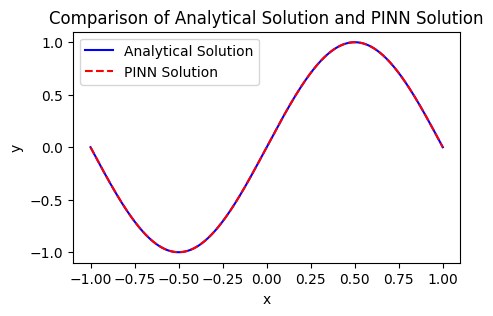

In [17]:
# Plotting
plt.figure(figsize=(5, 3))
plt.plot(x_test_np, y_true, 'b-', label='Analytical Solution')
plt.plot(x_test_np, y_pred, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Analytical Solution and PINN Solution')
plt.show()

## Problem Definition: Nonlinear time dependent Burger's equation
We will solve the following one-dimensional Burgers' equation:

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu\frac{\partial^2u}{\partial x^2}, \qquad x \in [-1, 1], \quad t \in [0, 1]$$

with the Dirichlet boundary conditions and initial conditions:

$$u(-1, t) = u(1, t) = 0, \quad u(x, 0) = - \sin(\pi x)$$.

where:
- $u$ is the solution as a function of space and time, $u(x, t)$.
- $\nu$ is the viscosity coefficient, which controls the smoothness of the solution, in this tutorial, it is considered as $0.01/\pi$.

In [17]:
# Define the neural network model class for 2 input and 1 output
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 20),  # 2 input dimensions (x and t)
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),            
            nn.Linear(20, 1)   # 1 output dimension (u)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t along the second axis
        u = self.hidden(inputs)
        return u

In [18]:
def pde(x,t, model):
    x.requires_grad = True
    t.requires_grad = True
    y = model(x,t)
    dy_dx = torch.autograd.grad(y, x, grad_outputs = torch.ones_like(y), create_graph=True)[0]
    dy_dt = torch.autograd.grad(y, t, grad_outputs = torch.ones_like(y), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x, grad_outputs = torch.ones_like(dy_dx), create_graph=True)[0]
    # residue
    return dy_dt + y*dy_dx -(0.01/np.pi)*d2y_dx2

In [ ]:
def compute_loss(model, x, x_bc, y_bc):
    res = pde(x, model)
    loss_pde =  torch.mean(res**2)

    # BC loss
    y_bc_pred = model(x_bc)
    loss_bc = torch.mean((y_bc - y_bc_pred)**2)

    # IC Loss
    loss_ic = 
    
    return loss_pde + loss_bc + loss_ic